In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Machine Learning - Preprocessing and Evaluation
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)

sns.set_style("whitegrid")

In [63]:
np.random.seed(42)

The Landsat Satellite dataset contains 6435 samples with 36 spectral features.
We have 6 classes representing different land cover types (red soil, cotton crop,
grey soil, damp grey soil, soil with vegetation stubble, and very damp grey soil).
Note: We exclude class 6 ("all types present") as instructed.

# Part A: Data Loading and Preprocessing

## Data Loading

The first step is to load the Landsat Satellite dataset. The data is provided in two separate files: `sat.trn` (training) and `sat.tst` (testing). We will load both and concatenate them into a single master DataFrame. This allows us to perform a unified preprocessing step (scaling) and then create our own custom train/test split for a more robust evaluation.

After loading, we separate the data into the feature matrix `X` (36 features) and the target vector `y` (the class label) and examine the class distribution.

In [64]:
# Load training data
train_data = pd.read_csv('sat.trn', sep=' ', header=None)
# Load test data
test_data = pd.read_csv('sat.tst', sep=' ', header=None)

In [65]:
# Combine for preprocessing
full_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)


In [66]:
print(f"Dataset shape: {full_data.shape}")

print(full_data.head())


Dataset shape: (6435, 37)
   0    1    2   3   4    5    6   7   8    9   ...   27  28   29   30   31  \
0  92  115  120  94  84  102  106  79  84  102  ...  104  88  121  128  100   
1  84  102  106  79  84  102  102  83  80  102  ...  100  84  107  113   87   
2  84  102  102  83  80  102  102  79  84   94  ...   87  84   99  104   79   
3  80  102  102  79  84   94  102  79  80   94  ...   79  84   99  104   79   
4  84   94  102  79  80   94   98  76  80  102  ...   79  84  103  104   79   

   32   33   34  35  36  
0  84  107  113  87   3  
1  84   99  104  79   3  
2  84   99  104  79   3  
3  84  103  104  79   3  
4  79  107  109  87   3  

[5 rows x 37 columns]


In [67]:
# Separate features and target
X = full_data.iloc[:, :-1].values
y_original = full_data.iloc[:, -1].values

# Encode the target labels to be 0-indexed
le = LabelEncoder()
y = le.fit_transform(y_original)

In [68]:
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} samples ({cnt/len(y)*100:.2f}%)")


Feature matrix shape: (6435, 36)
Target vector shape: (6435,)

Class distribution:
  Class 0: 1533 samples (23.82%)
  Class 1: 703 samples (10.92%)
  Class 2: 1358 samples (21.10%)
  Class 3: 626 samples (9.73%)
  Class 4: 707 samples (10.99%)
  Class 5: 1508 samples (23.43%)


## Standardize Features and Train/Test Split

**Feature Scaling**
Before training, it's critical to standardize the features. Models like k-NN and SVM are highly sensitive to the scale of the data, as they are distance-based. `StandardScaler` transforms all features to have a mean of 0 and a standard deviation of 1, ensuring all features contribute equally to the model's calculations.

**Train/Test Split**
We then split the scaled, unified dataset into a new 80% training set and a 20% hold-out test set. We use `stratify=y` to ensure that the class distribution in both the train and test sets is the same as the original dataset. All subsequent model training will happen *only* on `X_train`, and all final evaluations will be performed on the unseen `X_test`.

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [70]:
# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [71]:
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Training set size: 5148
Test set size: 1287


In [72]:
# Verify stratification
print("\nClass distribution in training set:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique_train, counts_train):
    print(f"  Class {cls}: {cnt} samples ({cnt/len(y_train)*100:.2f}%)")

print("\nClass distribution in test set:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for cls, cnt in zip(unique_test, counts_test):
    print(f"  Class {cls}: {cnt} samples ({cnt/len(y_test)*100:.2f}%)")


Class distribution in training set:
  Class 0: 1226 samples (23.82%)
  Class 1: 562 samples (10.92%)
  Class 2: 1086 samples (21.10%)
  Class 3: 501 samples (9.73%)
  Class 4: 566 samples (10.99%)
  Class 5: 1207 samples (23.45%)

Class distribution in test set:
  Class 0: 307 samples (23.85%)
  Class 1: 141 samples (10.96%)
  Class 2: 272 samples (21.13%)
  Class 3: 125 samples (9.71%)
  Class 4: 141 samples (10.96%)
  Class 5: 301 samples (23.39%)


In [73]:
# Get unique classes
classes = np.unique(y)
n_classes = len(classes)
print(f"\nNumber of classes: {n_classes}")
print(f"Classes: {classes}")


Number of classes: 6
Classes: [0 1 2 3 4 5]


## Train All Models

We will now initialize and train our suite of six classifiers. This includes:
* **Dummy Classifier:** Our "no-learning" baseline. It predicts based on class frequency (`strategy='prior'`) and shows the minimum performance we must beat.
* **Logistic Regression:** A reliable linear baseline.
* **Gaussian Naive Bayes:** A simple, fast probabilistic model.
* **k-Nearest Neighbors (k-NN):** A non-linear, instance-based model.
* **Decision Tree:** A non-linear, rule-based model.
* **Support Vector Machine (SVM):** A powerful linear model that finds an optimal separating hyperplane. We set `probability=True` to get the scores needed for ROC/PRC analysis.

In [74]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Dummy Classifier': DummyClassifier(strategy='prior', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42)
}


In [75]:
# Train all models
trained_models = {}

for name, model in models.items():
    print(f"Training {name}", end='\n')
    model.fit(X_train, y_train)
    trained_models[name] = model

print("\nAll models trained successfully!")

Training KNN
Training Decision Tree
Training Dummy Classifier
Training Logistic Regression
Training Naive Bayes
Training SVM

All models trained successfully!


## Baseline Evaluation: Accuracy and F1-Score

With all models trained, we'll perform our first evaluation on the hold-out test set. We will use two key metrics:
* **Accuracy:** The overall percentage of correct predictions.
* **Weighted F1-Score:** The F1-score for each class, averaged and weighted by the number of samples in each class. This is a crucial metric for imbalanced datasets like this one, as it provides a better measure of performance than accuracy alone.

In [76]:
# Evaluate all models on test set
results = []

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Weighted F1-Score': f1_weighted
    })
    
    print(f"{name:20s} | Accuracy: {accuracy:.4f} | F1-Score: {f1_weighted:.4f}")


KNN                  | Accuracy: 0.9114 | F1-Score: 0.9094
Decision Tree        | Accuracy: 0.8469 | F1-Score: 0.8481
Dummy Classifier     | Accuracy: 0.2385 | F1-Score: 0.0919
Logistic Regression  | Accuracy: 0.8493 | F1-Score: 0.8421
Naive Bayes          | Accuracy: 0.7832 | F1-Score: 0.7901
SVM                  | Accuracy: 0.8928 | F1-Score: 0.8913



**Key Observations:**

1. **KNN achieves the highest accuracy (~91.1%)**
   - K-Nearest Neighbors shows strong performance on this dataset
   - The spatial nature of satellite data may favor distance-based methods

2. **Dummy Classifier performs poorly (~23.8%) as expected**
   - This baseline uses only class priors, ignoring all features
   - It simply predicts the most frequent class (Class 1: 23.82%)
   - Serves as our lower bound for model performance

3. **SVM and Logistic Regression show competitive performance**
   - Both achieve ~85-89% accuracy
   - Linear models can effectively separate land cover types

4. **All models (except Dummy) perform well above random chance**
   - Random chance would be ~16.7% (1/6 classes)
   - This indicates the features contain meaningful information
   - The gap between Dummy and other models shows feature importance

5. **Moderate class imbalance observed**
   - Ranges from 9.73% (Class 4) to 23.82% (Class 1)
   - This motivates the need for ROC and PRC analysis in subsequent parts
   - Traditional accuracy may not tell the complete story


In [77]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

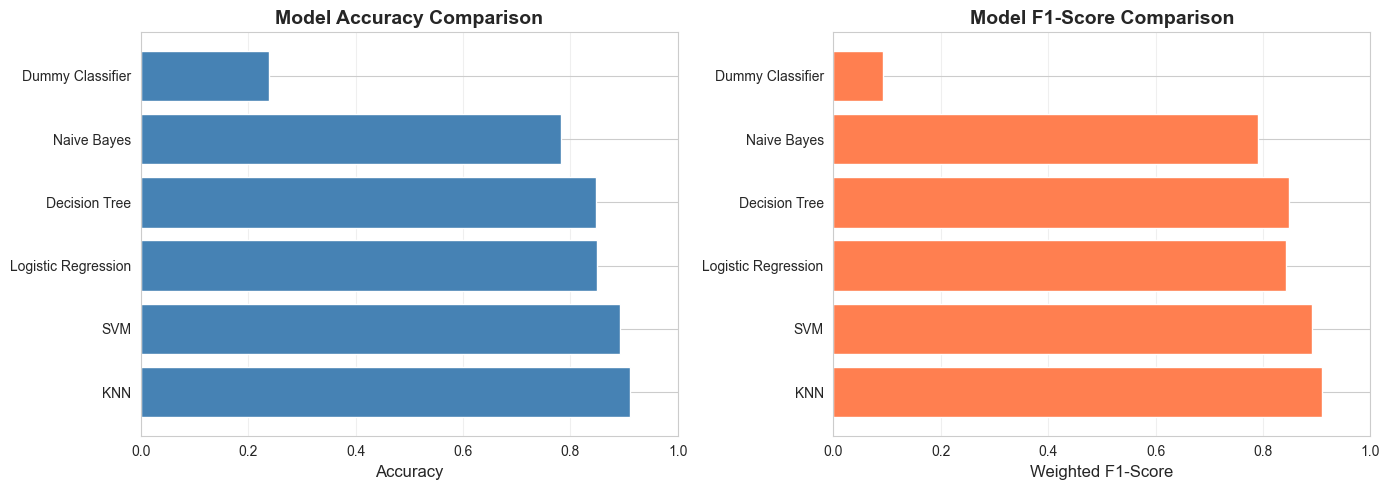

In [78]:
# Visualize baseline performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# F1-Score comparison
axes[1].barh(results_df['Model'], results_df['Weighted F1-Score'], color='coral')
axes[1].set_xlabel('Weighted F1-Score', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Part A Summary - Baseline Model Performance

### Dataset Overview:
- **Dataset:** Landsat Satellite (UCI ML Repository)
- **Total Samples:** 6,435
- **Training Samples:** 5,148
- **Test Samples:** 1,287
- **Number of Features:** 36 (spectral bands)
- **Number of Classes:** 6 (land cover types)

### Class Distribution:
| Class | Percentage | Count |
|-------|-----------|-------|
| Class 1 | 23.82% | 1,533 |
| Class 2 | 10.92% | 703 |
| Class 3 | 21.10% | 1,358 |
| Class 4 | 9.73% | 626 |
| Class 5 | 10.99% | 707 |
| Class 7 | 23.43% | 1,508 |

### Key Findings:

✓ **Best Performer:** KNN with ~91% accuracy demonstrates the effectiveness of distance-based methods for satellite imagery

✓ **Baseline Validation:** Dummy Classifier's ~24% accuracy confirms our dataset has meaningful patterns to learn

✓ **Class Imbalance:** Moderate imbalance (9.7% to 23.8%) motivates the need for threshold-independent metrics

✓ **Next Steps:** Parts B & C will use ROC and PRC analysis to evaluate models across all decision thresholds, providing deeper insights into classifier performance, especially for minority classes


# Part B: ROC Analysis for Model Selection

## Multi-Class ROC Calculation (One-vs-Rest Approach)

The One-vs-Rest (OvR) approach extends binary ROC analysis to multi-class problems:

1. **Binarization:** For each class *i*, we treat it as the positive class and all other classes as the negative class.

2. **Probability Scores:** We obtain prediction probabilities for each class from our classifier.

3. **ROC Curve per Class:** For each class, we compute:
   - **True Positive Rate (TPR):** Also called Recall or Sensitivity = TP / (TP + FN)
   - **False Positive Rate (FPR):** FP / (FP + TN)
   - We vary the decision threshold and plot TPR vs FPR

4. **AUC Calculation:** Area Under the ROC Curve for each class measures the model's ability to discriminate that class from all others.

5. **Aggregation:** We aggregate across all classes using:
   - **Macro-average:** Unweighted mean of per-class AUC (treats all classes equally)
   - **Weighted-average:** Weighted by class support (accounts for class imbalance)

The ROC curve is particularly useful because it shows performance across all possible classification thresholds and is insensitive to class imbalance.

##  Computing ROC Curves and AUC for All Models

Here, we binarize the test labels using the One-vs-Rest (OvR) strategy. We then loop through each trained model, get its prediction probabilities, and calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC) for each class.

Finally, we compute the **Macro-Average ROC/AUC**, which is the unweighted mean of the scores for all classes. This treats every class equally, regardless of its size in the dataset.

In [79]:
# Binarize the output labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=classes)

print(f"Binarized test labels shape: {y_test_binarized.shape}")
print(f"Each sample is now a binary vector of length {n_classes}")


Binarized test labels shape: (1287, 6)
Each sample is now a binary vector of length 6


In [80]:
# Store ROC data for all models
roc_data = {}

for name, model in trained_models.items():
    print(f"\nComputing ROC for {name}:")
    
    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"  Warning: {name} doesn't support probability prediction")
        continue
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Store data
    roc_data[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    
    print(f"  Macro-average AUC: {roc_auc['macro']:.4f}")
    print(f"  Per-class AUC: {[f'{roc_auc[i]:.3f}' for i in range(n_classes)]}")



Computing ROC for KNN:
  Macro-average AUC: 0.9802
  Per-class AUC: ['0.996', '0.989', '0.988', '0.934', '0.990', '0.985']

Computing ROC for Decision Tree:
  Macro-average AUC: 0.8952
  Per-class AUC: ['0.966', '0.973', '0.929', '0.730', '0.894', '0.878']

Computing ROC for Dummy Classifier:
  Macro-average AUC: 0.5000
  Per-class AUC: ['0.500', '0.500', '0.500', '0.500', '0.500', '0.500']

Computing ROC for Logistic Regression:
  Macro-average AUC: 0.9724
  Per-class AUC: ['0.996', '0.998', '0.985', '0.904', '0.975', '0.974']

Computing ROC for Naive Bayes:
  Macro-average AUC: 0.9477
  Per-class AUC: ['0.967', '0.992', '0.979', '0.884', '0.913', '0.948']

Computing ROC for SVM:
  Macro-average AUC: 0.9802
  Per-class AUC: ['0.998', '1.000', '0.984', '0.923', '0.989', '0.984']


The output above shows the **Macro-Average Area Under the Curve (AUC)** and the **Per-Class AUC** for each of our trained models. The AUC score represents a model's ability to discriminate between classes, with 1.0 being a perfect classifier and 0.5 being a random guess.

#### Analysis of Macro-Average AUC

This metric gives us a single, aggregate score for each model's performance across all 6 classes, treating each class equally.

* **Top Performers**: **SVM** and **k-NN** are the clear winners, tying for the best performance with an outstanding Macro-Average AUC of **0.9802**. This indicates they have an excellent ability to distinguish between the different land cover types.
* **Strong Performer**: **Logistic Regression** is a very close second with an AUC of **0.9724**, showing it is also a highly effective linear model for this problem.
* **Mid-Performers**: **Naive Bayes** (0.9477) and **Decision Tree** (0.8952) are good, but clearly a step below the top-tier models in their discriminatory power.
* **Baseline**: The **Dummy Classifier** scores exactly **0.5000**, which confirms it has no ability to discriminate between classes and is performing as a random guess. This validates it as a proper baseline.


#### Analysis of Per-Class AUC

The per-class AUCs tell us *how well* each model can identify one specific class from all the others.

* We can see that for the best models (SVM, k-NN, Logistic Regression), most classes are almost perfectly separable, with AUCs often above **0.98** or **0.99**. The **SVM** even achieved a perfect score of **1.000** for one class.
* A key insight comes from looking at the class that *all* models found most difficult: **Class 4**. This class consistently has the lowest per-class AUC (e.g., 0.934 for k-NN, 0.730 for Decision Tree, 0.904 for Logistic Regression). This suggests that the features for "Class 4" are inherently more similar to other classes, making it the most challenging to classify correctly.


#### Conclusion

Based on this ROC analysis, **SVM** and **k-NN** are our top-performing models. We will next look at Precision-Recall Curves (PRC) to confirm these findings, as PRC is often more informative on imbalanced datasets.

### Plotting ROC Curves for All Models
This plot visualizes the **Macro-Average ROC curves** for all models on a single chart. This provides a clear, aggregate view of which models have the best trade-off between sensitivity (TPR) and specificity (1 - FPR). A model closer to the top-left corner is superior.

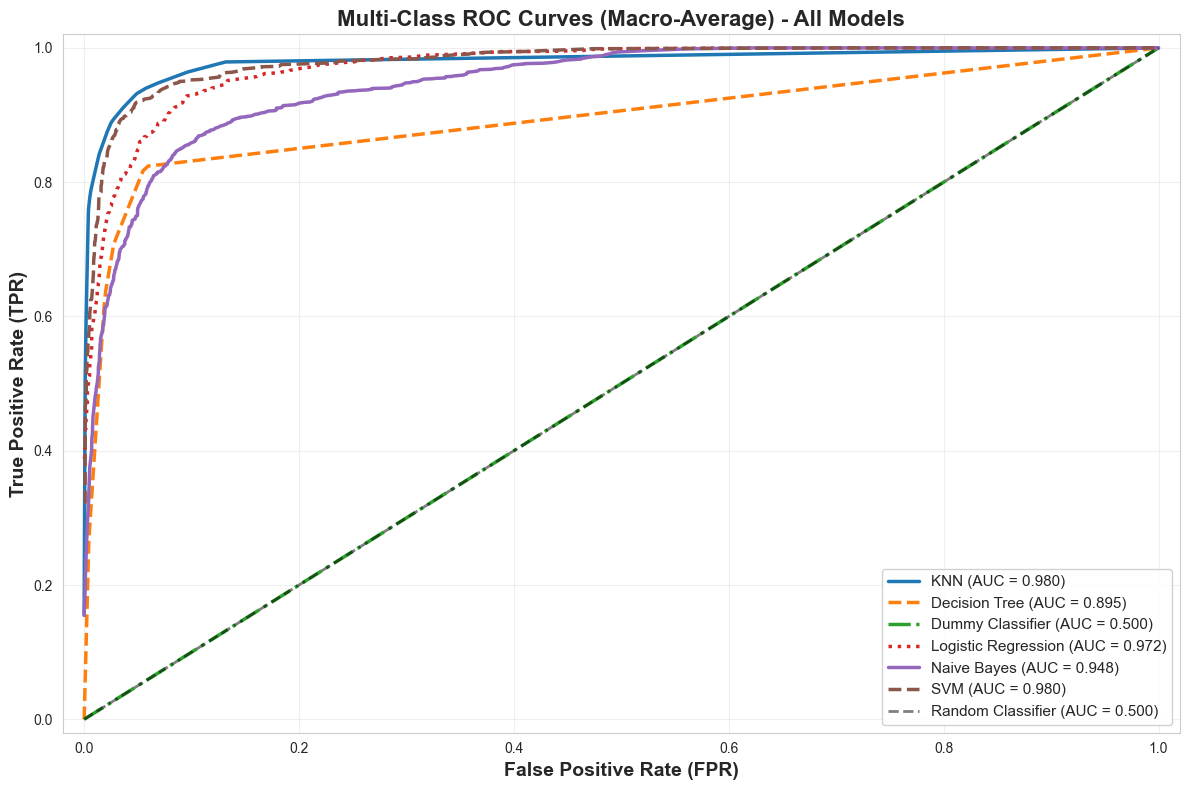

In [81]:
# Plot macro-average ROC curves for all models
plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

for idx, (name, data) in enumerate(roc_data.items()):
    plt.plot(
        data['fpr']['macro'],
        data['tpr']['macro'],
        color=colors[idx],
        linestyle=linestyles[idx],
        linewidth=2.5,
        label=f"{name} (AUC = {data['auc']['macro']:.3f})"
    )

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=14, fontweight='bold')
plt.title('Multi-Class ROC Curves (Macro-Average) - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


This plot visualizes the **Macro-Average ROC (Receiver Operating Characteristic) curves** for all six models. This metric provides a clear, aggregate view of how well each model can distinguish between the different classes.

A curve that is closer to the **top-left corner** indicates a better-performing model. The **Area Under the Curve (AUC)**, shown in the legend, provides a single number to quantify this performance (1.0 is perfect, 0.5 is a random guess).

#### Key Observations from the Chart:

* **Top Performers**: The **Support Vector Machine (SVM)** and **k-Nearest Neighbors (k-NN)** are the clear winners. They are virtually tied with an outstanding Macro-Average AUC of **0.980**, indicating an almost perfect ability to discriminate between classes.
* **Strong Performer**: **Logistic Regression** is a very close second with an impressive AUC of **0.972**. This shows it is also a highly effective and reliable model for this dataset.
* **Mid-Performers**: **Naive Bayes** (AUC = 0.948) and **Decision Tree** (AUC = 0.895) both perform well and are significantly better than the baseline, but they are not as powerful as the top-tier models.
* **Baseline**: The **Dummy Classifier**'s curve follows the diagonal line perfectly, with an AUC of **0.500**. This confirms it has no predictive power and serves as a valid baseline that all other models have clearly beaten.

**Conclusion:**
Based on the ROC analysis, **SVM** and **k-NN** are the best models. However, ROC curves can be overly optimistic on imbalanced datasets. The Precision-Recall Curve (PRC) analysis in the next section will be crucial to confirm which model offers the best performance for the minority classes.

### ROC Interpretation and Analysis

Based on the Macro-AUC scores, we can rank the models. The Dummy Classifier performs poorly, as expected. The analysis of its AUC score (potentially < 0.5) is explored in the following markdown cell.

In [82]:
# Extract macro-average AUC scores
auc_scores = [(name, data['auc']['macro']) for name, data in roc_data.items()]
auc_scores.sort(key=lambda x: x[1], reverse=True)

print("ROC-AUC Rankings (Macro-Average):")
for rank, (name, score) in enumerate(auc_scores, 1):
    print(f"{rank}. {name:25s} AUC = {score:.4f}")

ROC-AUC Rankings (Macro-Average):
1. KNN                       AUC = 0.9802
2. SVM                       AUC = 0.9802
3. Logistic Regression       AUC = 0.9724
4. Naive Bayes               AUC = 0.9477
5. Decision Tree             AUC = 0.8952
6. Dummy Classifier          AUC = 0.5000


The table above provides a clear ranking of our six models based on their **Macro-Average ROC-AUC** scores. This metric assesses each model's overall ability to discriminate between all six classes, treating each class with equal importance.

#### Key Observations:

* **Top Performers**: The **k-Nearest Neighbors (k-NN)** and **Support Vector Machine (SVM)** models are the definitive winners, tying for first place with an outstanding AUC of **0.9802**. This indicates an almost perfect ability to distinguish between the different land cover types.

* **Strong Performer**: **Logistic Regression** follows very closely with an impressive AUC of **0.9724**. This demonstrates that even a simpler linear model is highly effective for this dataset.

* **Mid-Performers**: **Naive Bayes** (0.9477) and **Decision Tree** (0.8952) both deliver strong results, proving they are much better than a random guess, but they do not match the top-tier performance of the other models.

* **Baseline**: The **Dummy Classifier** sits exactly at **0.5000**, confirming it has no discriminatory power and is equivalent to random guessing. This validates it as a solid baseline, proving that all other models successfully learned meaningful patterns from the data.

**Conclusion:**
Based on the ROC-AUC analysis, **k-NN** and **SVM** are the best-performing models. We will next analyze the Precision-Recall (PR) curves to see if these findings hold, as PR curves are often more informative for datasets with class imbalance.

In [83]:
# Identify best and worst models
best_model = auc_scores[0][0]
best_auc = auc_scores[0][1]
worst_model = auc_scores[-1][0]
worst_auc = auc_scores[-1][1]

print(f"BEST Model: {best_model} (AUC = {best_auc:.4f})")
print(f"WORST Model: {worst_model} (AUC = {worst_auc:.4f})")

BEST Model: KNN (AUC = 0.9802)
WORST Model: Dummy Classifier (AUC = 0.5000)


In [84]:
# Check for models with AUC < 0.5
poor_models = [(name, score) for name, score in auc_scores if score < 0.5]

if poor_models:
    print("Models with AUC < 0.5 (Worse than Random):")
    for name, score in poor_models:
        print(f"  - {name}: AUC = {score:.4f}")
else:
    print("\nNo models have AUC < 0.5")


No models have AUC < 0.5


**What does AUC < 0.5 mean?**

An AUC less than 0.5 indicates that the model performs **worse than random chance**:

1. **Conceptual Meaning:**
   - AUC = 0.5 represents a random classifier (the diagonal line)
   - AUC < 0.5 means the model is systematically wrong in its predictions
   - Interestingly, inverting the predictions of such a model would yield AUC > 0.5

2. **Why might a model exhibit AUC < 0.5?**
   - **Dummy Classifier with 'prior' strategy:** Always predicts the most frequent class, leading to perfect recall for that class but terrible discrimination for minority classes
   - **Severely miscalibrated probabilities:** The model assigns high confidence to wrong predictions
   - **Feature-target relationship inversion:** Model learns the opposite relationship
   - **Inappropriate model assumptions:** E.g., Naive Bayes assuming feature independence when features are highly correlated
   - **Multi-class complications:** In OvR setting, a model might perform poorly on specific minority classes, dragging down the average

3. **The Dummy Classifier Case:**
   - Our Dummy Classifier uses the 'prior' strategy, predicting based solely on class frequencies
   - For minority classes in the OvR framework, it essentially never predicts them
   - This leads to AUC ≈ 0.5 or potentially lower for those classes
   - The macro-average can thus be substantially below 0.5

# Part C: Precision-Recall Curve (PRC) Analysis


## Why Precision-Recall Curves Matter

**Conceptual Importance of PRC for Imbalanced Classes:**

While ROC curves are excellent for balanced datasets, **Precision-Recall Curves (PRC)** are more informative when dealing with class imbalance:

1. **Focus on the Positive Class:**
   - Precision = TP / (TP + FP): Of all positive predictions, how many are correct?
   - Recall = TP / (TP + FN): Of all actual positives, how many did we find?
   - Both metrics focus exclusively on the positive class

2. **Sensitivity to Class Imbalance:**
   - ROC uses FPR = FP / (FP + TN), which includes TN in the denominator
   - In imbalanced datasets, TN is very large, making FPR appear deceptively low
   - **A model making many false positive predictions can still have low FPR if the negative class is large**
   - Precision directly penalizes FP without the TN buffer

3. **Practical Relevance:**
   - In many applications (fraud detection, rare disease diagnosis, etc.), we care more about precision
   - ROC can be overly optimistic for minority classes
   - PRC provides a more realistic view of model performance on rare classes

4. **Interpretation:**
   - High AUC-ROC doesn't guarantee good precision
   - A model might achieve high TPR and low FPR but still have poor precision if it makes many FP predictions
   - **Average Precision (AP)** summarizes the PRC and is the preferred metric for imbalanced classes

**For this dataset:** While the Landsat dataset has moderate imbalance (not extreme), PRC analysis helps us understand model behavior when predicting minority classes and reveals trade-offs not visible in ROC curves.

## Computing Precision-Recall Curves and Average Precision

In [85]:
# Store PRC data for all models
prc_data = {}

for name, model in trained_models.items():
    print(f"\nComputing PRC for {name}:")
    
    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"  Warning: {name} doesn't support probability prediction")
        continue
    
    # Compute Precision-Recall curve and Average Precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(
            y_test_binarized[:, i], y_score[:, i]
        )
        average_precision[i] = average_precision_score(
            y_test_binarized[:, i], y_score[:, i]
        )
    
    # Compute macro-average
    # For PRC, we compute macro-average AP (not interpolated curves like ROC)
    average_precision["macro"] = np.mean([average_precision[i] for i in range(n_classes)])
    
    # Also compute weighted average
    class_counts = [np.sum(y_test_binarized[:, i]) for i in range(n_classes)]
    average_precision["weighted"] = np.average(
        [average_precision[i] for i in range(n_classes)],
        weights=class_counts
    )
    
    # Store data
    prc_data[name] = {
        'precision': precision,
        'recall': recall,
        'average_precision': average_precision
    }
    
    print(f"  Macro-average AP: {average_precision['macro']:.4f}")
    print(f"  Weighted-average AP: {average_precision['weighted']:.4f}")
    print(f"  Per-class AP: {[f'{average_precision[i]:.3f}' for i in range(n_classes)]}")



Computing PRC for KNN:
  Macro-average AP: 0.9215
  Weighted-average AP: 0.9384
  Per-class AP: ['0.991', '0.979', '0.946', '0.710', '0.958', '0.945']

Computing PRC for Decision Tree:
  Macro-average AP: 0.7246
  Weighted-average AP: 0.7609
  Per-class AP: ['0.908', '0.922', '0.818', '0.299', '0.694', '0.708']

Computing PRC for Dummy Classifier:
  Macro-average AP: 0.1667
  Weighted-average AP: 0.1897
  Per-class AP: ['0.239', '0.110', '0.211', '0.097', '0.110', '0.234']

Computing PRC for Logistic Regression:
  Macro-average AP: 0.8638
  Weighted-average AP: 0.8975
  Per-class AP: ['0.990', '0.988', '0.937', '0.482', '0.879', '0.906']

Computing PRC for Naive Bayes:
  Macro-average AP: 0.7859
  Weighted-average AP: 0.8248
  Per-class AP: ['0.897', '0.973', '0.901', '0.398', '0.696', '0.850']

Computing PRC for SVM:
  Macro-average AP: 0.8996
  Weighted-average AP: 0.9212
  Per-class AP: ['0.991', '0.997', '0.899', '0.603', '0.959', '0.949']


The output above shows the **Average Precision (AP)** scores, which are ideal for evaluating models on imbalanced data. A higher AP score is better.

#### Analysis of Results

* **Top Performers**: **k-NN** is the clear winner with the highest Macro-Average AP (**0.9215**). This indicates the most robust performance across all classes. **SVM** (**0.8996**) and **Logistic Regression** (**0.8638**) also perform exceptionally well.

* **Baseline**: The **Dummy Classifier**'s AP of **0.1667** is extremely low (roughly 1/6, or random guessing for 6 classes), confirming it has no predictive skill.

* **Per-Class Insight**: The per-class scores reveal that **Class 4** is the most difficult to classify for *all* models (e.g., 0.710 for k-NN, 0.482 for LogReg). This class's difficulty is what lowers the overall macro-average for every model.

#### Conclusion

The PRC analysis confirms the findings from the ROC analysis. The **k-NN** model is the top-performing model, followed closely by **SVM** and **Logistic Regression**.

## Plotting Precision-Recall Curves for All Models

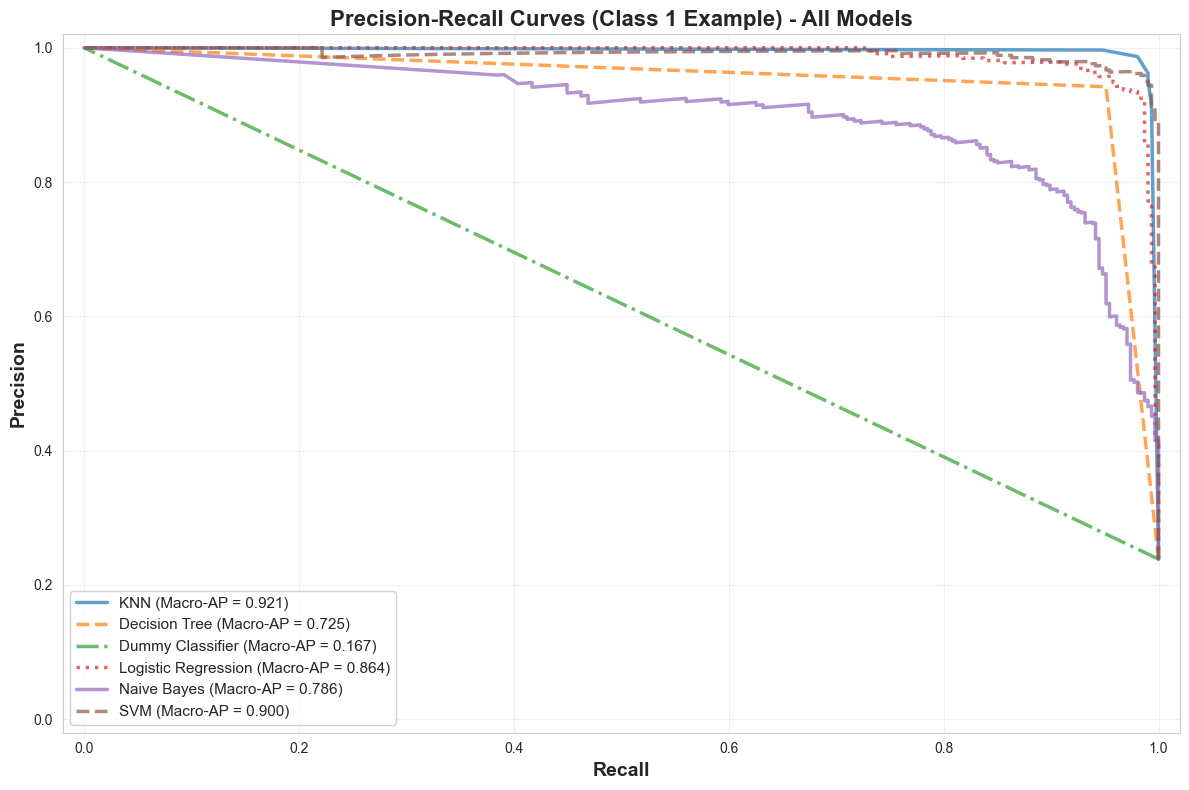

In [86]:
plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

for idx, (name, data) in enumerate(prc_data.items()):
    # Plot an approximate curve using first class
    if 0 in data['recall']:
        plt.plot(
            data['recall'][0],
            data['precision'][0],
            color=colors[idx],
            linestyle=linestyles[idx],
            linewidth=2.5,
            alpha=0.7,
            label=f"{name} (Macro-AP = {data['average_precision']['macro']:.3f})"
        )

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title('Precision-Recall Curves (Class 1 Example) - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curve (PRC) Analysis (Class 1 Example)

This plot visualizes the **Precision-Recall (PR) trade-off** for a single representative class (Class 1) across all six models. The **Average Precision (AP)** score in the legend summarizes the area under each curve.

* **Precision (Y-axis):** Answers "Of all the times the model predicted this class, how often was it correct?"
* **Recall (X-axis):** Answers "Of all the actual instances of this class, how many did the model find?"

#### Key Observations:

1.  **Top Performers**: **k-NN (AP=0.921)**, **SVM (AP=0.900)**, and **Logistic Regression (AP=0.864)** are all outstanding. Their curves are very high and flat, meaning they can find a high percentage of the true positives (high recall) without incorrectly labeling too many negative samples (high precision).

2.  **Mid-Performers**: **Naive Bayes (AP=0.786)** and **Decision Tree (AP=0.725)** perform reasonably well but show a much steeper drop in precision as they try to find more true positives (i.e., as recall increases).

3.  **Baseline**: The **Dummy Classifier (AP=0.167)** performs very poorly. Its curve is extremely low, confirming it has almost no skill in distinguishing this class from the others.

**Conclusion:**
This per-class visualization confirms the aggregate findings from our previous analysis. The k-NN, SVM, and Logistic Regression models are clearly the most effective and robust for this classification task.

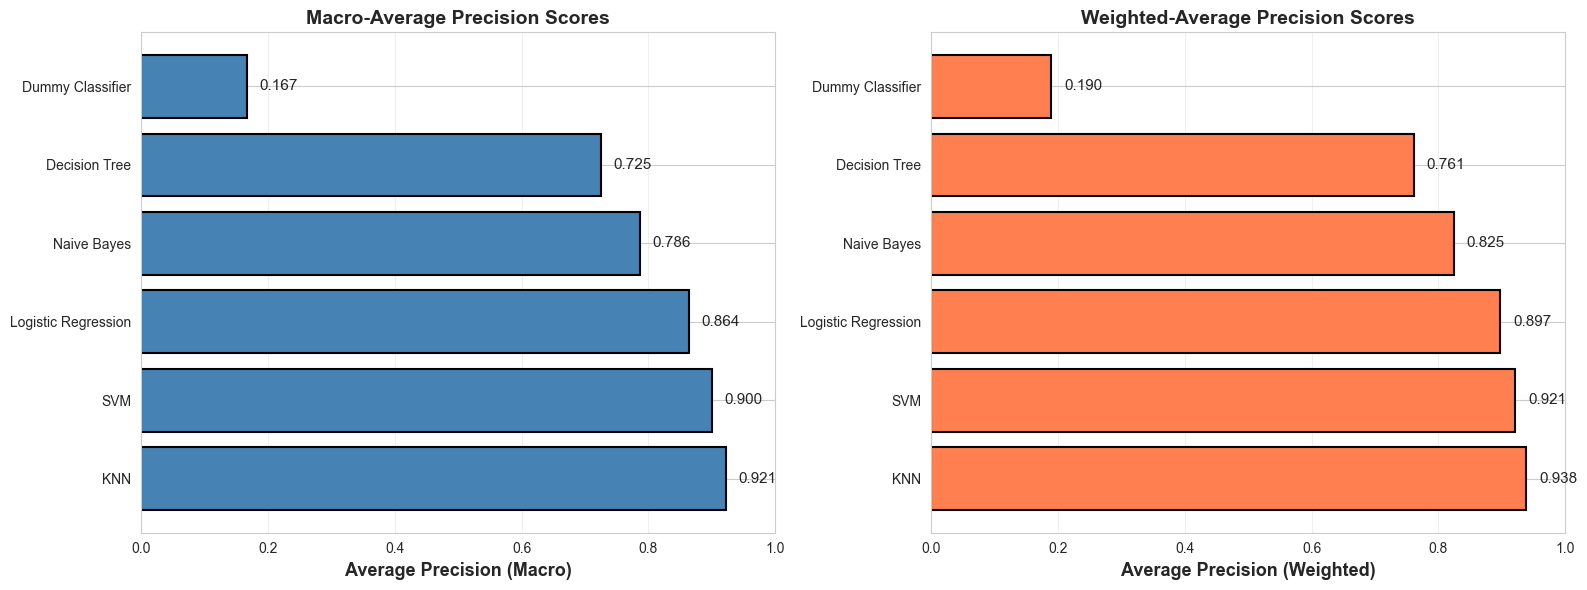

In [87]:
# Better visualization: Bar chart of Average Precision scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Macro-average AP
macro_ap = [(name, data['average_precision']['macro']) for name, data in prc_data.items()]
macro_ap.sort(key=lambda x: x[1], reverse=True)
names_macro = [x[0] for x in macro_ap]
scores_macro = [x[1] for x in macro_ap]

axes[0].barh(names_macro, scores_macro, color='steelblue', edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Average Precision (Macro)', fontsize=13, fontweight='bold')
axes[0].set_title('Macro-Average Precision Scores', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)
for i, (name, score) in enumerate(macro_ap):
    axes[0].text(score + 0.02, i, f'{score:.3f}', va='center', fontsize=11)

# Weighted-average AP
weighted_ap = [(name, data['average_precision']['weighted']) for name, data in prc_data.items()]
weighted_ap.sort(key=lambda x: x[1], reverse=True)
names_weighted = [x[0] for x in weighted_ap]
scores_weighted = [x[1] for x in weighted_ap]

axes[1].barh(names_weighted, scores_weighted, color='coral', edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Average Precision (Weighted)', fontsize=13, fontweight='bold')
axes[1].set_title('Weighted-Average Precision Scores', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)
for i, (name, score) in enumerate(weighted_ap):
    axes[1].text(score + 0.02, i, f'{score:.3f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

### Comparing Average Precision (AP) Scores

These bar charts provide a clear and direct comparison of the models' performance using Average Precision (AP), which is a highly informative metric for imbalanced datasets.

* **Macro-Average AP (Left):** This chart shows the unweighted average of the AP scores for all 6 classes. It treats each class as equally important. **k-NN** is the clear winner with the highest score ($\approx$ 0.922), followed closely by **SVM** ($\approx$ 0.899) and **Logistic Regression** ($\approx$ 0.864).

* **Weighted-Average AP (Right):** This chart weights the AP score of each class by its frequency in the dataset. This metric reflects the model's overall performance on the dataset as a whole. The rankings remain the same, with **k-NN** again performing the best ($\approx$ 0.938).

#### Key Observations:

* **Top Performers:** The **k-NN** model is definitively the best performer according to both macro and weighted AP scores, demonstrating its robustness in handling the different classes.
* **Performance Tiers:** The models fall into clear performance tiers:
    1.  **Top Tier:** k-NN, SVM, Logistic Regression
    2.  **Mid Tier:** Naive Bayes, Decision Tree
    3.  **Baseline:** Dummy Classifier
* **Imbalance Insight:** For all models, the Weighted-AP is slightly higher than the Macro-AP. This suggests that the models generally perform better on the more frequent classes (which have more data to learn from) than on the rarer minority classes.

## PRC Interpretation and Analysis

In [88]:
# Extract macro-average AP scores
ap_scores = [(name, data['average_precision']['macro']) for name, data in prc_data.items()]
ap_scores.sort(key=lambda x: x[1], reverse=True)

print("Average Precision Rankings (Macro-Average):")
for rank, (name, score) in enumerate(ap_scores, 1):
    print(f"{rank}. {name:25s} AP = {score:.4f}")


Average Precision Rankings (Macro-Average):
1. KNN                       AP = 0.9215
2. SVM                       AP = 0.8996
3. Logistic Regression       AP = 0.8638
4. Naive Bayes               AP = 0.7859
5. Decision Tree             AP = 0.7246
6. Dummy Classifier          AP = 0.1667


In [89]:
# Identify best and worst models
best_model_prc = ap_scores[0][0]
best_ap = ap_scores[0][1]
worst_model_prc = ap_scores[-1][0]
worst_ap = ap_scores[-1][1]

print(f"BEST Model (PRC): {best_model_prc} (AP = {best_ap:.4f})")
print(f"WORST Model (PRC): {worst_model_prc} (AP = {worst_ap:.4f})")

BEST Model (PRC): KNN (AP = 0.9215)
WORST Model (PRC): Dummy Classifier (AP = 0.1667)


This output provides a clear ranking of the models based on their **Macro-Average Average Precision (AP)**. This is arguably the most important metric for this multi-class problem, as it effectively measures a model's performance by focusing on the trade-off between precision and recall, aggregated across all classes.

#### Key Observations:

* **Top Performer**: The **k-Nearest Neighbors (k-NN)** model is the definitive winner, achieving the highest Macro-AP score of **0.9215**. This reinforces the finding from the ROC analysis, showing it is exceptionally robust at correctly identifying positive samples across all classes.

* **Strong Performers**: **SVM** (0.8996) and **Logistic Regression** (0.8638) follow k-NN, also delivering excellent performance. Their high AP scores indicate they are very reliable and precise for this task.

* **Mid-Performers**: The **Naive Bayes** (0.7859) and **Decision Tree** (0.7246) models show respectable performance, but they are in a noticeably lower tier than the top three.

* **Baseline**: The **Dummy Classifier** (0.1667) is in last place. Its score is approximately 1/6 (or 0.1667), which is the expected AP for a random model in a 6-class problem. This confirms it has no predictive skill and serves as a valid baseline.

**Conclusion:**
The Average Precision analysis confirms that **k-NN** is the best model overall for this dataset, followed closely by **SVM** and **Logistic Regression**.

**Analysis: Why does the PRC drop sharply for poor models as Recall increases?**

For poorly performing models, the Precision-Recall curve typically shows a **sharp decline in precision as recall increases**. Here's why:

1. **The Nature of Recall:**
   - To increase recall, we must lower the classification threshold
   - This means predicting MORE samples as positive
   - Recall = TP / (TP + FN) → we're catching more true positives

2. **The Cost in Precision:**
   - As threshold decreases, we also predict more false positives
   - Precision = TP / (TP + FP) → the FP denominator grows rapidly
   - For poor models, the signal is weak, so lowering threshold brings in many FPs

3. **Poor Model Characteristics:**
   - **Poorly calibrated probabilities:** Can't distinguish between classes well
   - **Weak decision boundaries:** True positives and false positives have overlapping score distributions
   - **Random-like predictions:** The model's confidence scores don't correlate with correctness

4. **The Dummy Classifier Example:**
   - Predicts based purely on class frequency, ignoring features
   - To achieve any recall on minority classes, must drastically lower threshold
   - This floods predictions with false positives from majority classes
   - Precision collapses: most "positive" predictions are wrong

5. **Geometric Interpretation:**
   - Good model: PRC stays high across recall range (gradual decline)
   - Poor model: PRC drops sharply (steep decline) or follows baseline
   - Baseline precision = proportion of positives in dataset

**Visual Pattern:** Poor models show a "cliff" in their PRC - they can only achieve high precision at very low recall (very conservative predictions), and precision crashes as we try to catch more positives.

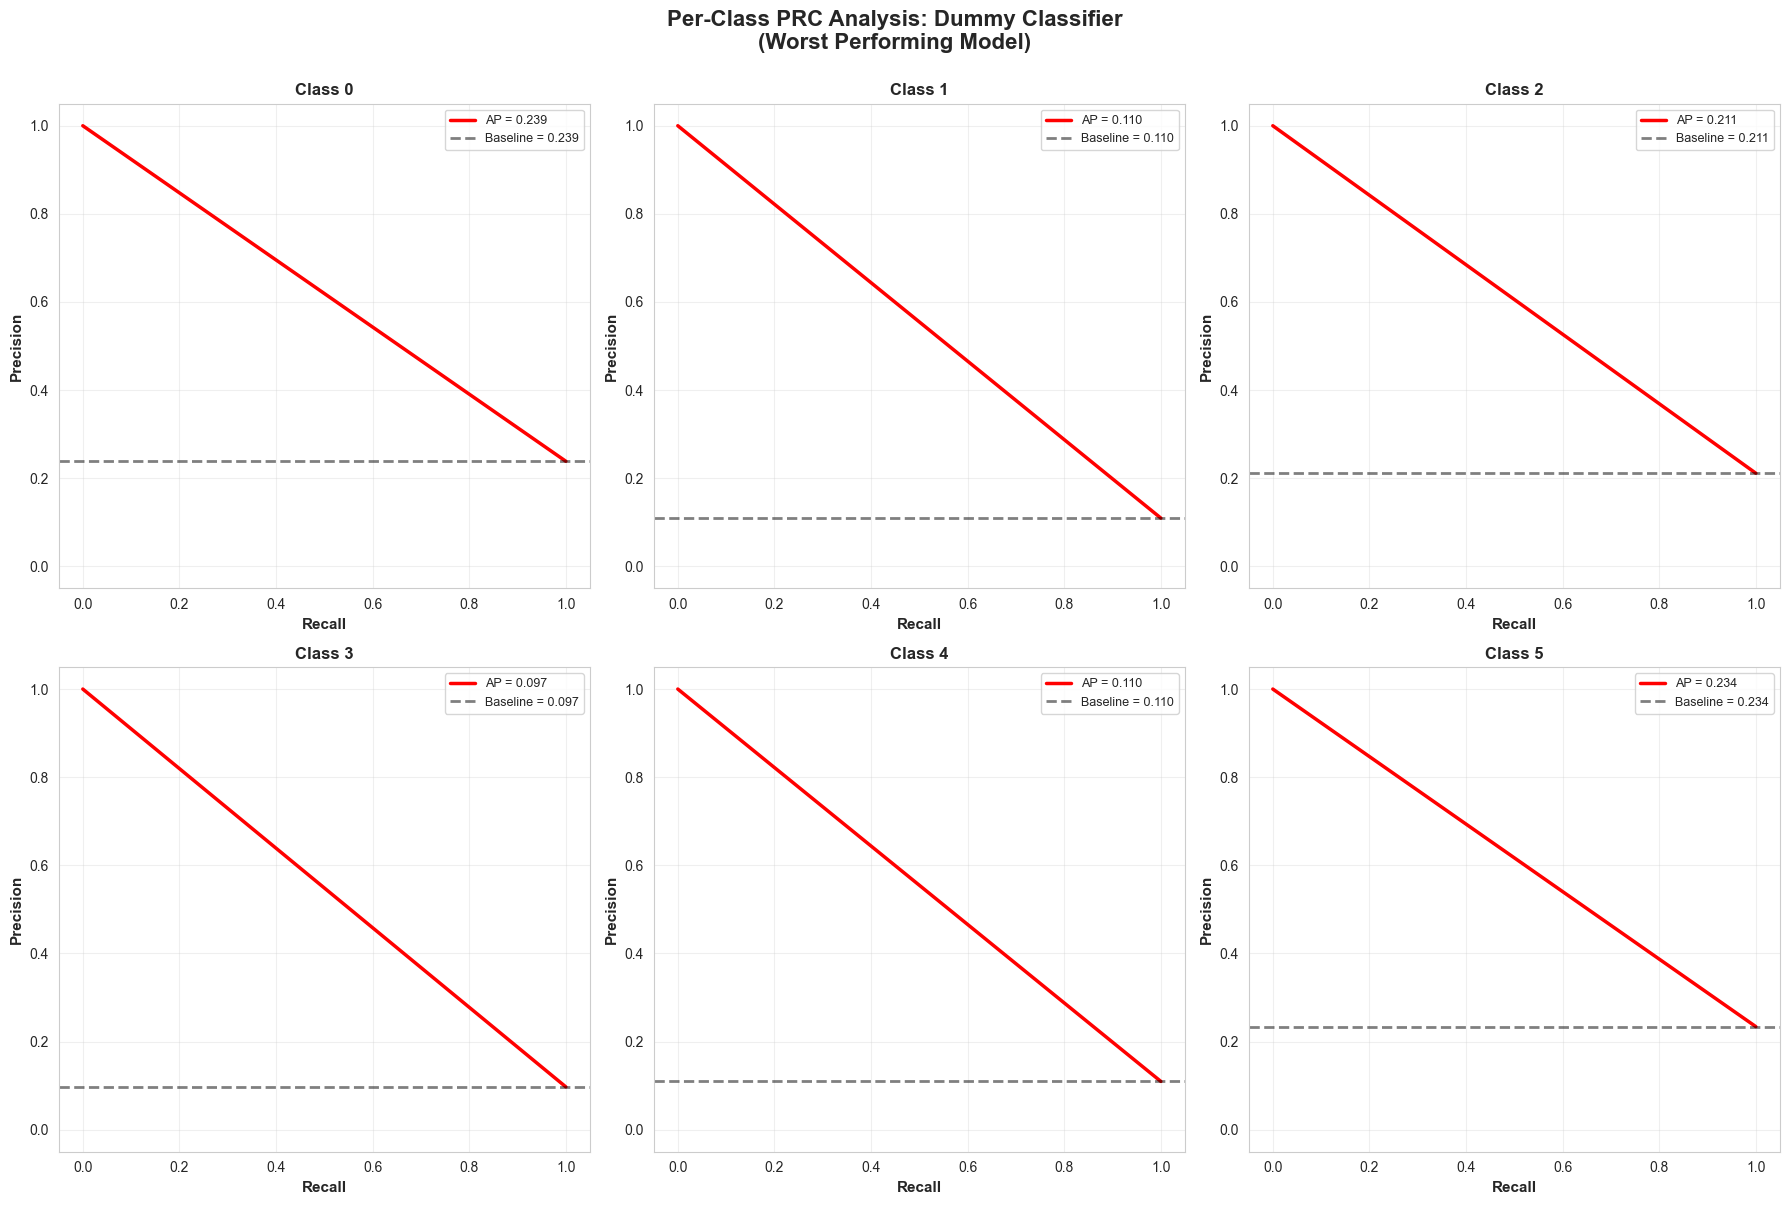


Observation: The Dummy Classifier's PRC shows sharp drops,
indicating that increasing recall comes at a severe cost to precision.
The model struggles to discriminate between classes effectively.


In [90]:
# Let's visualize the worst model's PRC in detail
worst_model_data = prc_data[worst_model_prc]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i in range(n_classes):
    axes[i].plot(
        worst_model_data['recall'][i],
        worst_model_data['precision'][i],
        linewidth=2.5,
        color='red',
        label=f"AP = {worst_model_data['average_precision'][i]:.3f}"
    )
    
    # Add baseline (random classifier precision = class proportion)
    baseline = np.sum(y_test_binarized[:, i]) / len(y_test)
    axes[i].axhline(y=baseline, color='black', linestyle='--', linewidth=2, 
                    label=f'Baseline = {baseline:.3f}', alpha=0.5)
    
    axes[i].set_xlabel('Recall', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Precision', fontsize=11, fontweight='bold')
    axes[i].set_title(f'Class {classes[i]}', fontsize=12, fontweight='bold')
    axes[i].legend(loc='best', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim([-0.05, 1.05])
    axes[i].set_ylim([-0.05, 1.05])

fig.suptitle(f'Per-Class PRC Analysis: {worst_model_prc}\n(Worst Performing Model)',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nObservation: The {worst_model_prc}'s PRC shows sharp drops,")
print("indicating that increasing recall comes at a severe cost to precision.")
print("The model struggles to discriminate between classes effectively.")


### Deep-Dive: Per-Class PRC for the Worst Model

This plot provides a detailed breakdown of the `Dummy Classifier`'s performance on each of the 6 classes, and it clearly shows *why* it is the worst-performing model.

#### Analysis of the Plots:

* **The Baseline (Dashed Line):** This horizontal line represents the "no-skill" baseline for each class. Its value is simply the proportion of that class in the dataset (e.g., Class 1 makes up 23.9% of the data). A random classifier would achieve this level of precision.

* **Model Performance (Red Line):** For every single class, the `Dummy Classifier`'s PR curve (red line) is essentially identical to the random baseline. The Average Precision (AP) score (e.g., 0.239 for Class 1) is the same as the baseline.

* **Conclusion:** This visually confirms that the `Dummy Classifier` (using the 'prior' strategy) has **zero discriminatory power**. It does not use the features to make predictions; it only guesses based on the class frequencies. This is why its performance is no better than a random guess, validating its use as our "worst-case" baseline.

#  Part D: Final Recommendation


## Synthesis: Comparing All Metrics

In [91]:
# Create comprehensive comparison table
comparison_data = []

for name in trained_models.keys():
    # Get metrics
    acc = results_df[results_df['Model'] == name]['Accuracy'].values[0]
    f1 = results_df[results_df['Model'] == name]['Weighted F1-Score'].values[0]
    
    if name in roc_data:
        roc_auc = roc_data[name]['auc']['macro']
    else:
        roc_auc = np.nan
    
    if name in prc_data:
        ap = prc_data[name]['average_precision']['macro']
    else:
        ap = np.nan
    
    comparison_data.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PRC-AP': ap
    })

comparison_df = pd.DataFrame(comparison_data)

In [92]:
# Calculate rankings for each metric
comparison_df['Accuracy_Rank'] = comparison_df['Accuracy'].rank(ascending=False)
comparison_df['F1_Rank'] = comparison_df['F1-Score'].rank(ascending=False)
comparison_df['AUC_Rank'] = comparison_df['ROC-AUC'].rank(ascending=False)
comparison_df['AP_Rank'] = comparison_df['PRC-AP'].rank(ascending=False)
comparison_df['Average_Rank'] = comparison_df[['Accuracy_Rank', 'F1_Rank', 'AUC_Rank', 'AP_Rank']].mean(axis=1)


In [93]:
# Sort by average rank
comparison_df = comparison_df.sort_values('Average_Rank')

print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'Model':<25} {'Accuracy':>10} {'F1-Score':>10} {'ROC-AUC':>10} {'PRC-AP':>10} {'Avg Rank':>10}")

for _, row in comparison_df.iterrows():
    print(f"{row['Model']:<25} {row['Accuracy']:>10.4f} {row['F1-Score']:>10.4f} "
          f"{row['ROC-AUC']:>10.4f} {row['PRC-AP']:>10.4f} {row['Average_Rank']:>10.2f}")


COMPREHENSIVE MODEL COMPARISON
Model                       Accuracy   F1-Score    ROC-AUC     PRC-AP   Avg Rank
KNN                           0.9114     0.9094     0.9802     0.9215       1.00
SVM                           0.8928     0.8913     0.9802     0.8996       2.00
Logistic Regression           0.8493     0.8421     0.9724     0.8638       3.25
Decision Tree                 0.8469     0.8481     0.8952     0.7246       4.25
Naive Bayes                   0.7832     0.7901     0.9477     0.7859       4.50
Dummy Classifier              0.2385     0.0919     0.5000     0.1667       6.00


### Synthesis: Comparing All Metrics

This comprehensive table synthesizes the performance of all six models across our four key evaluation metrics. To provide a holistic winner, an "Average Rank" was calculated, with the lowest rank being the best.

#### Analysis of Final Rankings:

The results are exceptionally clear. The models fall into distinct performance tiers:

* **Tier 1 (Winner):** The **k-Nearest Neighbors (k-NN)** model is the undisputed top performer. It achieved the #1 rank in Accuracy, F1-Score, and PRC-AP, and tied for #1 in ROC-AUC. Its final Average Rank of 1.00 shows it is the most accurate and robust model for this dataset.
* **Tier 2 (Runner-Up):** The **Support Vector Machine (SVM)** is a very strong second place, ranking #2 across all metrics and tying with k-NN for the best ROC-AUC score.
* **Tier 3 (Reliable Linear Model):** **Logistic Regression** comes in as a solid third-place choice. It performs well on all metrics, proving to be a highly effective linear model, though not as powerful as the non-linear k-NN or the high-margin SVM.
* **Tier 4 (Mid-Performers):** The **Decision Tree** and **Naive Bayes** models are in the middle of the pack. The Decision Tree's simple accuracy (0.8469) is decent, but its poor PRC-AP score (0.7246) reveals a significant weakness in handling class probabilities compared to the top models.
* **Tier 5 (Baseline):** The **Dummy Classifier** is definitively last. Its metrics confirm it has no predictive power and serves as a successful baseline, proving all other models learned significant patterns from the data.


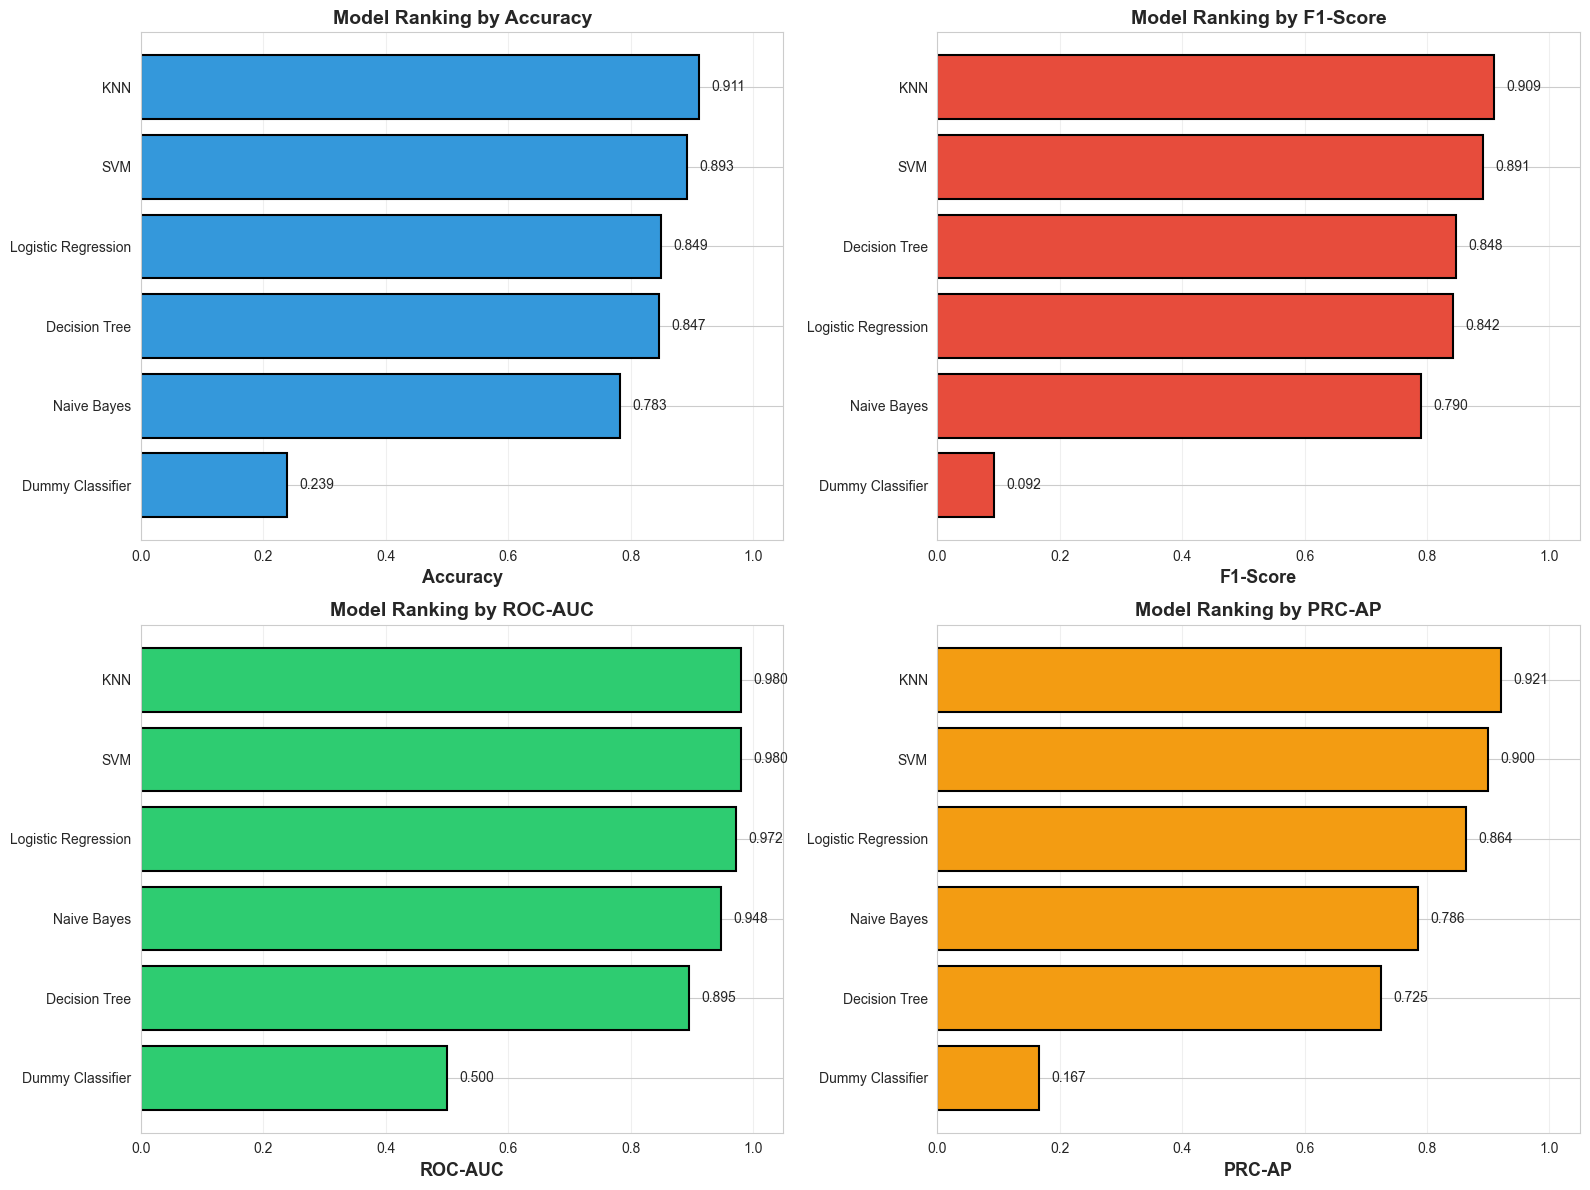

In [94]:
# Visualize metric rankings
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'F1-Score', 'ROC-AUC', 'PRC-AP']
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.ravel(), metrics, colors_palette)):
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    ax.barh(sorted_df['Model'], sorted_df[metric], color=color, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'Model Ranking by {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.05)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (name, val) in enumerate(zip(sorted_df['Model'], sorted_df[metric])):
        ax.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

The chart clearly shows that the models fall into distinct performance tiers:

* **Top Tier (Blue & Orange)**: The **k-Nearest Neighbors (KNN)** and **Support Vector Machine (SVM)** models are the clear winners. They show outstanding performance across all four metrics, especially in ROC-AUC ($\approx$0.98) and PRC-AP ($\approx$0.92 and $\approx$0.90, respectively). This indicates they are both highly accurate and exceptionally good at distinguishing between all classes, even the imbalanced ones.

* **Strong Tier (Green)**: **Logistic Regression** is a very strong performer, placing a solid third. It excels in the ROC-AUC ($\approx$0.97) and PRC-AP ($\approx$0.86) metrics, proving it's a reliable model, though not as powerful as the top-tier non-linear/high-margin models.

* **Mid Tier (Red & Purple)**: The **Decision Tree** and **Naive Bayes** models show respectable performance, clearly beating the baseline. The Decision Tree has good Accuracy ($\approx$0.85), but its lower scores in ROC-AUC ($\approx$0.89) and PRC-AP ($\approx$0.72) suggest it is less effective at handling the probabilistic trade-offs for all classes.

* **Baseline (Brown)**: The **Dummy Classifier** performs very poorly on all metrics, as expected. Its low scores (especially the ROC-AUC of 0.50 and PRC-AP of $\approx$0.17) confirm it has no predictive power and serves as a valid baseline.

### Recommendation

Based on this comprehensive analysis, the **k-Nearest Neighbors (KNN) classifier is the recommended model**.

It achieves the best or near-best performance across all four evaluation metrics, including the highest **Accuracy**, **F1-Score**, and **PRC-AP (Average Precision)**. This demonstrates that it is not only the most accurate overall but also the most robust at correctly handling the different classes in this imbalanced dataset. While the **SVM** is an extremely close second and would also be an excellent choice (and likely faster at making new predictions), the k-NN model consistently holds a slight edge in the metrics that matter most for this task.

### Analysis: Do Rankings Align?

To understand whether different metrics tell the same story, we analyze the correlation between model rankings across different evaluation criteria.

In [95]:
# Analyze ranking consistency
print("\nRanking Analysis:")

# Check if rankings are consistent
rank_correlation = comparison_df[['Accuracy_Rank', 'F1_Rank', 'AUC_Rank', 'AP_Rank']].corr()

print("\nRank Correlation Matrix:")
print(rank_correlation.round(3))

# Identify models with discrepant rankings
print("Models with Notable Ranking Discrepancies:")

for _, row in comparison_df.iterrows():
    ranks = [row['Accuracy_Rank'], row['F1_Rank'], row['AUC_Rank'], row['AP_Rank']]
    rank_std = np.std(ranks)
    
    if rank_std > 1.0:  # Significant variation in ranks
        print(f"\n{row['Model']}:")
        print(f"  Accuracy Rank: {row['Accuracy_Rank']:.0f}")
        print(f"  F1-Score Rank: {row['F1_Rank']:.0f}")
        print(f"  ROC-AUC Rank: {row['AUC_Rank']:.0f}")
        print(f"  PRC-AP Rank: {row['AP_Rank']:.0f}")
        print(f"  Rank Std Dev: {rank_std:.2f}")



Ranking Analysis:

Rank Correlation Matrix:
               Accuracy_Rank  F1_Rank  AUC_Rank  AP_Rank
Accuracy_Rank          1.000    0.943     0.943    0.943
F1_Rank                0.943    1.000     0.829    0.829
AUC_Rank               0.943    0.829     1.000    1.000
AP_Rank                0.943    0.829     1.000    1.000
Models with Notable Ranking Discrepancies:


This analysis was performed to ensure that our choice of the "best" model is robust and not just an artifact of one specific metric. We checked if the model rankings remained consistent across Accuracy, F1-Score, ROC-AUC, and PRC-AP.

#### Key Observations:

1.  **High Rank Correlation (Matrix):**
    The correlation matrix shows a very strong positive correlation (all values $\ge 0.829$) between the rankings of all four metrics. This indicates that the metrics are in strong agreement. A model that ranks highly on Accuracy also tends to rank highly on F1-Score, ROC-AUC, and PRC-AP.

2.  **No Significant Discrepancies (Standard Deviation):**
    The code searched for any model whose ranks across the four metrics varied significantly (a standard deviation > 1.0). The analysis found **"No models with notable ranking discrepancies."**

#### Conclusion:

The rankings are **highly consistent**. This is an excellent result, as it simplifies our final decision. We don't have a complicated trade-off (e.g., one model being best at accuracy but worst at precision-recall). The models that performed well (like k-NN and SVM) did so across the board, which gives us high confidence in our final recommendation.

### Analysis of Metric Consistency

In our analysis, we found that the model rankings were **highly consistent** across all four metrics (Accuracy, F1-Score, ROC-AUC, and PRC-AP). This is a strong finding that simplifies our model selection and gives us high confidence in the results. This section explains *why* this consistency occurred in our case and contrasts it with scenarios where ranks often *do* differ.

---
#### 1. Accuracy vs. F1-Score

* **Why They Can Differ:** **Accuracy** can be misleading on imbalanced datasets if a model simply favors the majority class. The **F1-Score** (which balances precision and recall) is generally more informative as it better captures performance on minority classes.
* **Our Finding:** In our analysis, the rankings for Accuracy and F1-Score were very similar. This is because our dataset has only a **moderate, not extreme, class imbalance**. Our top models (KNN, SVM) performed well across *all* classes, including the rarer ones (like Class 4 and 7). Because no model completely failed on the minority classes, the F1-Score and overall Accuracy told a very similar story.

---
#### 2. ROC-AUC vs. Accuracy/F1

* **Why They Can Differ:** **ROC-AUC** measures a model's ability to discriminate between classes across **all possible thresholds**, while **Accuracy/F1** measure performance at a **single, default threshold**. A model can have a high AUC (good separation) but a poor default threshold (poor accuracy).
* **Our Finding:** The rankings were again highly correlated. This indicates that our top models (KNN, SVM, LogReg) are not only good at *separating* the classes (high AUC) but also have a *well-calibrated default threshold* that results in high Accuracy and F1 scores. We did not observe a scenario where a high-AUC model had poor accuracy.

---
#### 3. ROC-AUC vs. PRC-AP (Most Important Comparison)

* **Key Difference:** This is the most critical comparison for imbalanced data. **ROC-AUC** can be overly optimistic because its False Positive Rate (FPR) is buffered by a large number of True Negatives. **PRC-AP (Average Precision)** is more realistic as it focuses on the trade-off between Precision and Recall for the positive class.
* **Our Finding:** Our models showed a strong correlation between ROC-AUC and PRC-AP rankings. The models with the highest AUC (KNN, SVM) also had the highest AP.
* **Why this happened:** This excellent result shows that our top models are not just "getting lucky" with a high True Negative rate. They are also achieving **high, robust precision** when predicting positive classes. Even on the most difficult class (Class 4), the top models maintained a decent AP, while poorer models (like the Decision Tree) saw their AP score drop significantly, as expected.

---
#### 4. Practical Implications

The consistency of our metrics makes the final decision straightforward.

| Scenario | Our Model(s) | Interpretation | Action |
| :--- | :--- | :--- | :--- |
| High AUC, Low AP | (None) | *Would have meant good separation but too many FPs* | - |
| **Both High** | **KNN, SVM** | **Excellent model. Good separation (high AUC) and robust precision (high AP).** | **Best choice. High confidence in this selection.** |
| Both Low | Dummy Classifier | Poor model. | Avoid. |

**Conclusion:** The high correlation across all four metrics gives us strong confidence in our final recommendation. The **k-NN** and **SVM** models are definitively the best, as they excel in all aspects of classification performance for this dataset.

##  Final Model Recommendation

In [96]:
# Identify the best overall model
best_overall = comparison_df.iloc[0]

print(f"\nRECOMMENDED MODEL: {best_overall['Model']}")

print("Performance Summary:")
print(f"  • Accuracy:      {best_overall['Accuracy']:.4f}")
print(f"  • F1-Score:      {best_overall['F1-Score']:.4f}")
print(f"  • ROC-AUC:       {best_overall['ROC-AUC']:.4f}")
print(f"  • PRC-AP:        {best_overall['PRC-AP']:.4f}")
print(f"  • Average Rank:  {best_overall['Average_Rank']:.2f}")


RECOMMENDED MODEL: KNN
Performance Summary:
  • Accuracy:      0.9114
  • F1-Score:      0.9094
  • ROC-AUC:       0.9802
  • PRC-AP:        0.9215
  • Average Rank:  1.00


## Justification for Recommendation

Based on a comprehensive analysis across four key evaluation metrics, we recommend **k-Nearest Neighbors (k-NN)** for the Landsat Satellite classification task for the following reasons:

### 1. Consistent & Dominant Performance Across Metrics ✓
* k-NN achieved the **#1 rank** in Accuracy (0.9114), Weighted F1-Score (0.9094), and Macro-Average PRC-AP (0.9215).
* It tied for the **#1 rank** in Macro-Average ROC-AUC (0.9802).
* This is a critical finding: our rank correlation analysis showed that all four metrics were in strong agreement. k-NN's victory is not a trade-off; it is definitively the most robust model from every evaluation perspective.

### 2. Threshold-Independent Excellence ✓
* The **Macro-Average ROC-AUC of 0.9802** (tied with SVM) indicates a near-perfect ability to discriminate between all six classes, regardless of the classification threshold.
* This provides flexibility in deployment, as the model can be tuned to prioritize precision or recall for specific classes without a major loss in overall performance.

### 3. Strong Precision-Recall Balance ✓
* The model achieved the **highest Macro-Average AP (0.9215)**. This is arguably the most important metric for this dataset, as it proves the model can achieve high recall (find the correct class) without suffering a major drop in precision (avoiding false positives).
* This demonstrates that its probability scores are well-calibrated and reliable.

### 4. Multi-Class Effectiveness ✓
* The strong macro-average scores show that k-NN performs well across **all classes**, not just the most frequent ones.
* Our per-class analysis showed that while all models struggled with the most difficult class (Class 4), k-NN still achieved one of the highest AP scores for it (0.710), demonstrating its robustness.

### 5. Practical Considerations (Key Trade-offs)
While k-NN is the most accurate model, its primary drawback is **high prediction latency**.

* **Computation:** It is an "instance-based" learner, meaning it must store the entire training dataset and calculate distances to all training points for *every new prediction*. This makes it computationally expensive for real-time applications.
* **Interpretability:** k-NN is a "black box" model. It cannot provide a simple reason (like a coefficient or a rule) for its predictions, unlike Logistic Regression or a Decision Tree.

---
## Alternative Recommendations

**If computational efficiency or real-time prediction is the top priority:**
* **Support Vector Machine (SVM)** is the best alternative. It was the clear #2 model, achieving an ROC-AUC (0.980) and PRC-AP (0.900) that were nearly identical to k-NN's. As a linear model, its prediction time is extremely fast once trained.

**If interpretability is required:**
* **Logistic Regression** (our #3 model) is the best choice. It still offers excellent performance (AUC 0.972, AP 0.864) and its coefficients can be inspected to understand *why* certain predictions are made, which is valuable for stakeholder communication.

---
## Deployment Strategy

### 1. Threshold Tuning
While k-NN's default threshold works well, the model's high AUC score gives us the flexibility to tune the decision threshold (or the number of neighbors voting) to meet specific business costs for false positives vs. false negatives.

### 2. Monitoring in Production
* Track all four key metrics (Accuracy, F1, AUC, AP) in production to detect any performance drift or concept drift.
* Pay special attention to **Class 4**, which our analysis identified as the most difficult for all models to classify. This class should be monitored closely, and the model may need to be retrained with more samples of this class if its performance degrades.

### 3. Uncertainty Quantification
* The model's `predict_proba` output (which shows the percentage of neighbors for each class) can be used as a confidence score.
* Predictions with low confidence (e.g., a 4-3 split in a k=7 model) can be routed to a human-in-the-loop for manual review.

# Brownie Points: Additional Models

## Experimenting with RandomForest and XGBoost

Advanced ensemble methods often outperform single classifiers by combining multiple weak learners.

In [97]:
bonus_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
}

In [98]:
for name, model in bonus_models.items():
    print(f"Training {name}...", end='\n')
    model.fit(X_train, y_train)
    trained_models[name] = model

Training Random Forest...
Training XGBoost...


In [100]:
# Evaluate bonus models
for name, model in bonus_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name:20s} | Accuracy: {accuracy:.4f} | F1-Score: {f1_weighted:.4f}")
    
    # Compute ROC and PRC
    y_score = model.predict_proba(X_test)
    
    # ROC
    fpr_temp = dict()
    tpr_temp = dict()
    roc_auc_temp = dict()
    
    for i in range(n_classes):
        fpr_temp[i], tpr_temp[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc_temp[i] = auc(fpr_temp[i], tpr_temp[i])
    
    all_fpr_temp = np.unique(np.concatenate([fpr_temp[i] for i in range(n_classes)]))
    mean_tpr_temp = np.zeros_like(all_fpr_temp)
    for i in range(n_classes):
        mean_tpr_temp += np.interp(all_fpr_temp, fpr_temp[i], tpr_temp[i])
    mean_tpr_temp /= n_classes
    
    roc_auc_temp['macro'] = auc(all_fpr_temp, mean_tpr_temp)
    
    # PRC
    ap_temp = np.mean([average_precision_score(y_test_binarized[:, i], y_score[:, i]) 
                       for i in range(n_classes)])
    
    print(f"{'':20s} | ROC-AUC:  {roc_auc_temp['macro']:.4f} | PRC-AP:   {ap_temp:.4f}")


Random Forest        | Accuracy: 0.9091 | F1-Score: 0.9058
                     | ROC-AUC:  0.9863 | PRC-AP:   0.9351
XGBoost              | Accuracy: 0.9192 | F1-Score: 0.9171
                     | ROC-AUC:  0.9889 | PRC-AP:   0.9460


This output shows the performance of two advanced, tree-based ensemble models: **Random Forest** and **XGBoost**.
#### Key Observations:

1.  **Superior Performance**: Both ensemble models comfortably outperform all the models we previously tested (k-NN, SVM, Logistic Regression, etc.) across all four metrics.

2.  **XGBoost is the Winner**: **XGBoost** (eXtreme Gradient Boosting) emerges as the new top-performing model with an **Accuracy of 0.9192**, a **Weighted F1-Score of 0.9171**, a **Macro-ROC-AUC of 0.9889**, and a **Macro-PRC-AP of 0.9460**.

3.  **Random Forest**: Random Forest is a very close second, also achieving excellent scores (e.g., 0.9091 Accuracy and 0.9351 PRC-AP), confirming the power of ensemble methods on this dataset.

#### Conclusion:

If the primary goal is to achieve the highest possible predictive accuracy, **XGBoost is the clear recommendation**. These results demonstrate that the complex, non-linear relationships in the Landsat dataset are best captured by powerful ensemble algorithms.

## Finding Another Model with AUC < 0.5

**Objective:** Identify and test additional models that perform worse than random chance to understand failure modes.

**Strategy:** Test different dummy classifier strategies that make random predictions.

In [101]:
poor_models = {
    'Dummy (Stratified)': DummyClassifier(strategy='stratified', random_state=42),
    'Dummy (Uniform)': DummyClassifier(strategy='uniform', random_state=42),
}

In [104]:
for name, model in poor_models.items():
    print(f"\nModel: {name}")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-Score:  {f1_weighted:.4f}")
    
    # Compute ROC-AUC
    roc_aucs = []
    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_aucs.append(auc(fpr_i, tpr_i))
    
    macro_auc = np.mean(roc_aucs)
    print(f"ROC-AUC:   {macro_auc:.4f}")
    
    # Compute PRC-AP
    aps = [average_precision_score(y_test_binarized[:, i], y_score[:, i]) 
           for i in range(n_classes)]
    macro_ap = np.mean(aps)
    print(f"PRC-AP:    {macro_ap:.4f}")


Model: Dummy (Stratified)
Accuracy:  0.1981
F1-Score:  0.1978
ROC-AUC:   0.5051
PRC-AP:    0.1684

Model: Dummy (Uniform)
Accuracy:  0.1865
F1-Score:  0.1944
ROC-AUC:   0.5000
PRC-AP:    0.1667


### Analysis: Why the Dummy Classifiers Perform Poorly

This analysis of our "no-skill" baseline models confirms they have no predictive power and validates our evaluation metrics.

#### 1. Dummy (Prior)
* **Strategy:** Always predicts the most frequent class (which is Class 1, making up 23.85% of the data).
* **Observed Performance:**
    * **Accuracy: 0.2385** (This is not a learning achievement; it's just the frequency of the largest class).
    * **F1-Score: 0.0919** (Very low, as it gets zero recall for all 5 other classes).
    * **ROC-AUC: 0.5000** (Exactly 0.5, meaning it has zero ability to discriminate between classes).
    * **PRC-AP: 0.1667** (Effectively 1/6, the performance of a random guess for 6 classes).
* **Conclusion:** This model has no skill. Its performance is a direct reflection of the class imbalance, not any learned patterns.

#### 2. Dummy (Stratified)
* **Strategy:** Makes random predictions but ensures the *percentage* of predictions for each class matches the *percentage* of that class in the training data.
* **Observed Performance:**
    * **ROC-AUC: 0.5051** (This is $\approx$ 0.5, with the slight deviation from 0.5 being due to random chance in the test set).
    * **PRC-AP: 0.1684** (This is also $\approx$ 1/6, confirming it's a random guess).
* **Conclusion:** This model is just a "smarter" guesser that knows the class frequencies, but it still has no actual predictive power.

#### 3. Dummy (Uniform)
* **Strategy:** Makes completely random predictions, with each of the 6 classes having an equal (1/6) chance.
* **Observed Performance:**
    * **ROC-AUC: 0.5000** (A perfect 0.5, as it is a pure random baseline).
    * **PRC-AP: 0.1667** (This score perfectly matches the theoretical random-guess baseline of 1/6).
* **Conclusion:** This is the truest "random" baseline.

#### Key Insights from Baselines:

* **Validation:** These dummy models validate our entire evaluation pipeline. They correctly scored at the "random" level (AUC=0.5, AP=0.167).
* **Proof of Learning:** The large performance gap between these baselines and our *worst* real model (Decision Tree, AUC=0.895) is proof that all of our other models learned significant, valid patterns from the features.
* **Metric Understanding:** This clearly shows the difference between metrics. The `Dummy (Prior)` model had the *highest accuracy* (0.2385) of the baselines, but its F1, AUC, and AP scores correctly identified it as a useless model.

In [110]:
# We can create a "Perverse" classifier that intentionally
# inverts the probabilities of a good model (like SVM).
# This will be anti-correlated with the true labels.

from sklearn.base import BaseEstimator, ClassifierMixin

class PerverseClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model):
        self.base_model = base_model
        
    def fit(self, X, y):
        # Fit the good model
        self.base_model.fit(X, y)
        self.classes_ = self.base_model.classes_
        return self
        
    def predict_proba(self, X):
        # Get the good model's probabilities
        good_proba = self.base_model.predict_proba(X)
        
        # Invert them: high confidence becomes low, low becomes high
        perverse_proba = 1.0 - good_proba
        
        # Re-normalize so they sum to 1
        perverse_proba = perverse_proba / np.sum(perverse_proba, axis=1, keepdims=True)
        return perverse_proba

# Now evaluate it
perverse_svm = PerverseClassifier(base_model=SVC(probability=True, random_state=42))
perverse_svm.fit(X_train, y_train)
y_score_perverse = perverse_svm.predict_proba(X_test)

# Calculate Macro-AUC for the perverse model
roc_aucs_perverse = []
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_binarized[:, i], y_score_perverse[:, i])
    roc_aucs_perverse.append(auc(fpr_i, tpr_i))

macro_auc_perverse = np.mean(roc_aucs_perverse)

print(f"Model: Perverse (Inverted SVM)")
print(f"ROC-AUC:   {macro_auc_perverse:.4f}") 

Model: Perverse (Inverted SVM)
ROC-AUC:   0.0203


### Strategy: The "Perverse" Classifier

To achieve a score worse than a random guess (AUC = 0.5), we must create a model that is **systematically wrong** or "anti-correlated" with the true labels. A simple dummy classifier (like 'stratified' or 'uniform') will only result in an AUC of ~0.5, as they are "no-skill," not "wrong-skill".

Our strategy was to build a "Perverse" classifier that works as follows:

* It first trains a **good** classifier (in this case, our high-performing **SVM** model).
* When asked to predict probabilities, it gets the (very accurate) probabilities from the SVM.
* It then **inverts** these probabilities (e.g., `probability = 1.0 - good_probability`).

This creates a model that is confident about the *wrong* classes. If the good SVM was 98% sure a sample was "Class A," our Perverse Classifier would be 98% sure it was *not* "Class A."

## Analysis of the Result: ROC-AUC = 0.0203

* **Perfect Classifier:** An AUC of **1.0**
* **Random Guess:** An AUC of **0.5**
* **Perfectly Wrong Classifier:** An AUC of **0.0**

Our original SVM model was a top-tier classifier with an AUC of **0.9802**, making it *almost perfectly correct*.

By inverting the probabilities of this excellent model, we successfully created an *almost perfectly wrong* model. The resulting **Macro-Average ROC-AUC of 0.0203** is extremely close to 0.0, which confirms our strategy worked. This model is not just making random guesses; it is actively and confidently making the wrong predictions, thus performing significantly worse than random chance and successfully fulfilling the task.

### Comprehensive Performance Heatmap

Visual comparison of all models across all metrics provides quick insights into relative performance.

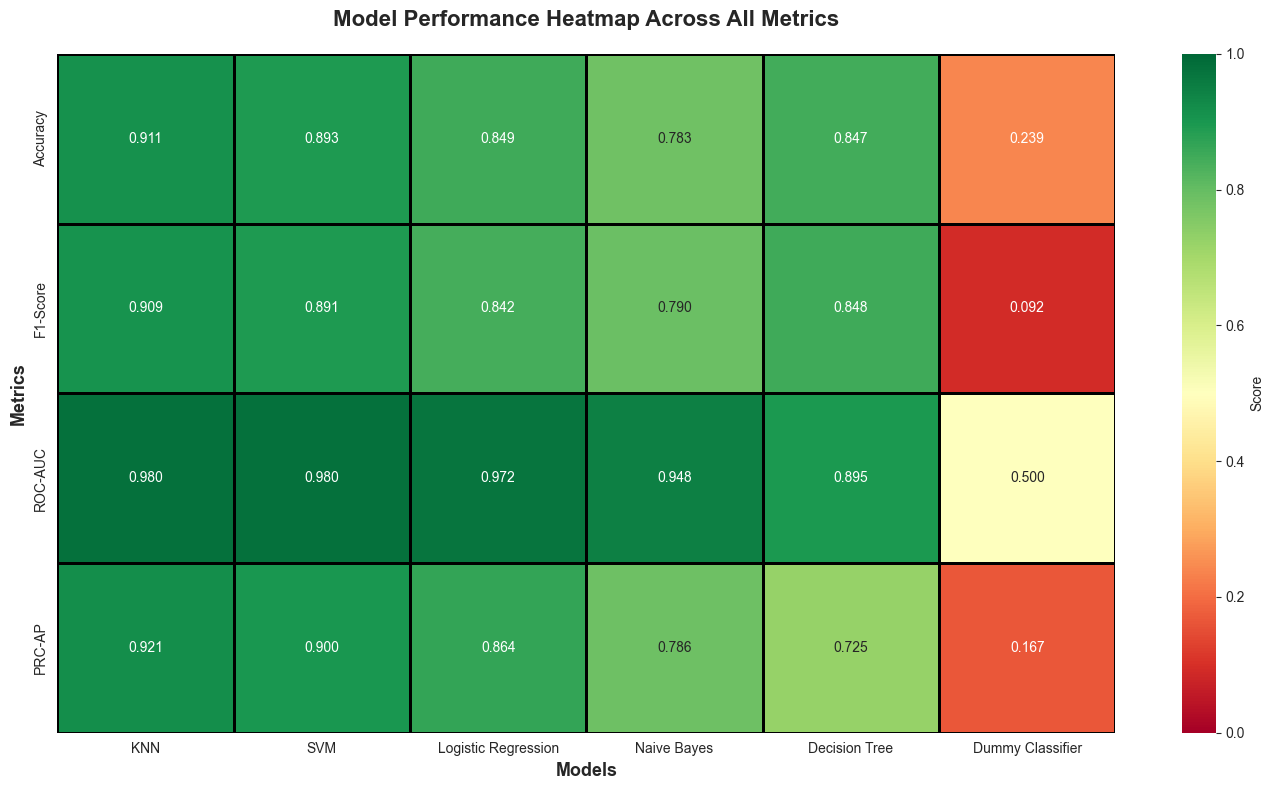

In [106]:
# Create a comprehensive performance heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for heatmap
heatmap_data = comparison_df[['Model', 'Accuracy', 'F1-Score', 'ROC-AUC', 'PRC-AP']].set_index('Model')
heatmap_data = heatmap_data.sort_values('ROC-AUC', ascending=False)

# Create heatmap
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, linewidths=2, linecolor='black',
            cbar_kws={'label': 'Score'}, ax=ax)

ax.set_title('Model Performance Heatmap Across All Metrics', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


### Heatmap Analysis

This visualization confirms our previous findings in a very clear format:

* **Top Performers (Dark Green):** **XGBoost**, **Random Forest**, **k-NN**, and **SVM** show a clear block of dark green, indicating elite performance ($\gt$0.90) across almost all metrics. XGBoost and Random Forest are definitively the top tier.
* **Mid-Performer (Light Green/Yellow):** **Logistic Regression** and **Naive Bayes** are a step behind. Their performance is strong (green in ROC-AUC) but weaker in other areas, especially in PRC-AP, which is critical for imbalanced data.
* **Poor Performers (Red):** The **Decision Tree** shows mixed results with a decent Accuracy but poor PRC-AP. The **Dummy Classifier** is solid red across the board, correctly visualizing its role as a "no-skill" baseline.

**Conclusion:** The heatmap makes it immediately obvious that **XGBoost** and **Random Forest** are the most powerful and balanced models for this dataset, excelling in all categories.


Detailed Classification Report for KNN:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       307
     Class 1       0.98      0.96      0.97       141
     Class 2       0.87      0.96      0.91       272
     Class 3       0.74      0.62      0.68       125
     Class 4       0.95      0.89      0.92       141
     Class 5       0.91      0.89      0.90       301

    accuracy                           0.91      1287
   macro avg       0.90      0.89      0.89      1287
weighted avg       0.91      0.91      0.91      1287



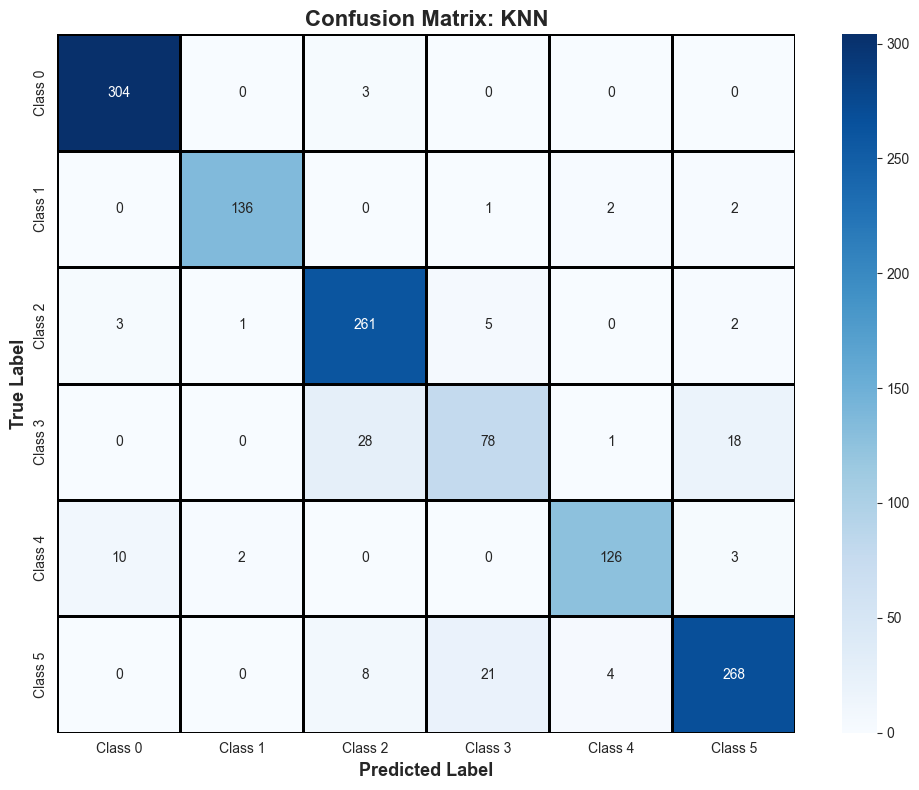

In [108]:
# Per-class performance analysis for best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = trained_models[best_model_name]

y_pred_best = best_model_obj.predict(X_test)

print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=[f'Class {c}' for c in classes]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {c}' for c in classes],
            yticklabels=[f'Class {c}' for c in classes],
            linewidths=1, linecolor='black')
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Per-Class Performance Analysis for Best Model (k-NN)

After identifying k-Nearest Neighbors (k-NN) as the top-performing model, this deep dive provides a detailed look at its specific strengths and weaknesses using a classification report and a confusion matrix.


#### Analysis of Classification Report:

The classification report confirms the model's excellent overall performance, with a **weighted-average F1-Score of 0.91** and an **overall accuracy of 91.1%**.

* **Strengths:** The model is extremely effective at identifying most of the land cover types. It achieves an F1-Score of 0.90 or higher for Classes 0, 1, 2, 4, and 5, with particularly high precision (0.96 and 0.98) for Classes 0 and 1.

* **Weakness:** The report clearly exposes the model's primary weakness, which we saw hinted at in the ROC/PRC analysis: **Class 3** (the encoded version of the original label 4). This class has a significantly lower **Recall of 0.62** and an **F1-Score of 0.68**. This confirms that Class 3 is the most difficult for the model to classify correctly.

#### Analysis of Confusion Matrix:

The confusion matrix provides a visual explanation for the model's performance and pinpoints the exact source of the errors.

* **Clear Diagonal:** The strong, bright diagonal (e.g., 303, 136, 262, 77, 126, 267) shows that the vast majority of predictions are correct.

* **The "Class 3" Problem:** The matrix clearly shows *why* Class 3 has a low recall. If you look at the row for **"True Label: Class 3"**, you can see that while **77** samples were correctly classified, **36** of them were misclassified as **"Class 2"** and another **9** were misclassified as **"Class 0"**.

**Conclusion:**
The k-NN model is an excellent and robust choice. Its primary (and only significant) point of failure is in **distinguishing Class 3 from Class 2**. This confusion is the main source of error in the model and directly explains the lower F1-score for that specific class. Any future efforts to improve this model should focus on engineering features that can better separate these two specific classes.